# Covid-19: Comparing cases and lockdowns in Berlin and Zurich

## Introduction
This project compares the Covid-19 cases in these Berlin and Canton Zurich and tries to answer three questions:

1. How do the statistics of the incidences in both locations compare? 
2. How does the progress of incidences in both locations compare?
3. What variables have influenced the progress of incidences? 

To answer the third question, an ARIMA model (time series perdiction model) will be used to find out which regulations (such as mask mandate or closing of schools, restaurants etc.) had an effect on the incidences or if other variables such as vaccinations and temperature had a stronger influence. 

## Table of Contents
<ol>
<li><a href="#gathering">Data gathering</a></li>
<li><a href="#assessment">Data Assessment</a></li>
<li><a href="#cleaning">Data Cleaning</a></li>
<li><a href="#analysis">Analysis, Modeling and Visualisation</a></li>
<li><a href="#limitations">Limitations</a></li>
</ol>

## 1. Data Gathering <a id='gathering'></a>

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# import csv files
cases_de = pd.read_csv('covid_cases_de.csv')
cases_zh_raw = pd.read_csv('covid_cases_zh.csv')
vacc_global = pd.read_csv('covid_vaccinations_global.csv')
lockdowns = pd.read_csv('lockdowns.csv', sep = ';')
temperature_be_raw = pd.read_csv('temperature_be.csv')
temperature_zh_raw = pd.read_csv('temperature_zh.csv', sep = ';')

## 2. Data Assessment <a id='assessment'></a>

### Berlin cases

In [3]:
cases_de[cases_de.state == 'Berlin'].head()

,state,county,age_group,gender,date,cases,deaths,recovered
293445,Berlin,SK Berlin Charlottenburg-Wilmersdorf,00-04,F,2020-03-31,1,0,1
293446,Berlin,SK Berlin Charlottenburg-Wilmersdorf,00-04,F,2020-04-07,1,0,1
293447,Berlin,SK Berlin Charlottenburg-Wilmersdorf,00-04,F,2020-04-10,1,0,1
293448,Berlin,SK Berlin Charlottenburg-Wilmersdorf,00-04,F,2020-05-12,1,0,1
293449,Berlin,SK Berlin Charlottenburg-Wilmersdorf,00-04,F,2020-07-20,1,0,1


In [4]:
cases_de[cases_de.state == 'Berlin'].tail()

,state,county,age_group,gender,date,cases,deaths,recovered
325606,Berlin,SK Berlin Treptow-Koepenick,NaN,M,2021-01-08,1,0,1
325607,Berlin,SK Berlin Treptow-Koepenick,NaN,M,2021-01-14,1,0,1
325608,Berlin,SK Berlin Treptow-Koepenick,NaN,M,2021-04-13,1,0,1
325609,Berlin,SK Berlin Treptow-Koepenick,NaN,NaN,2021-03-15,1,0,1
325610,Berlin,SK Berlin Treptow-Koepenick,NaN,NaN,2021-03-17,1,0,1


In [5]:
# check for misisng values
cases_de[cases_de.state == 'Berlin'].isnull().any()

state        False
county       False
age_group     True
gender        True
date         False
cases        False
deaths       False
recovered    False
dtype: bool

In [6]:
# check data types
cases_de[cases_de.state == 'Berlin'].dtypes

state        object
county       object
age_group    object
gender       object
date         object
cases         int64
deaths        int64
recovered     int64
dtype: object

In [7]:
cases_de[cases_de.state == 'Berlin'].describe()

,cases,deaths,recovered
count,32166.000000,32166.000000,32166.000000
mean,5.550022,0.108717,5.367966
std,6.809680,0.454311,6.805263
min,1.000000,0.000000,-1.000000
25%,1.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000
75%,7.000000,0.000000,7.000000
max,76.000000,16.000000,76.000000


#### Issues <a id='berlin_issues'></a>
1. Data frame needs to be filtered for Berlin data
2. Data needs to be added up within county, age and gender groups for each day
3. Only keep columns `date` and `cases`
4. Date column needs to be changed to date type
5. Unclear if there is data for each day
6. 7-day incidence needs to be calculated
7. Date range needs to be aligned with other data frames (necessary for planned regression model)

### Zurich cases

In [8]:
cases_zh_raw.head()

,date,time,abbreviation_canton_and_fl,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,source,current_isolated,current_quarantined,current_quarantined_riskareatravel,current_quarantined_total
0,2020-02-27,14:30,ZH,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,https://www.zh.ch/de/gesundheit/coronavirus.html,NaN,NaN,NaN,NaN
1,2020-02-28,14:30,ZH,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,https://www.zh.ch/de/gesundheit/coronavirus.html,NaN,NaN,NaN,NaN
2,2020-02-29,14:30,ZH,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,https://www.zh.ch/de/gesundheit/coronavirus.html,NaN,NaN,NaN,NaN
3,2020-03-01,14:30,ZH,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,https://www.zh.ch/de/gesundheit/coronavirus.html,NaN,NaN,NaN,NaN
4,2020-03-02,14:30,ZH,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,https://www.zh.ch/de/gesundheit/coronavirus.html,NaN,NaN,NaN,NaN


In [9]:
cases_zh_raw.tail()

,date,time,abbreviation_canton_and_fl,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,source,current_isolated,current_quarantined,current_quarantined_riskareatravel,current_quarantined_total
463,2021-06-04,14:30,ZH,NaN,111817,NaN,79.0,33.0,27.0,NaN,1405.0,https://www.zh.ch/de/gesundheit/coronavirus.html,699.0,1758.0,NaN,NaN
464,2021-06-05,14:30,ZH,NaN,111873,NaN,77.0,35.0,26.0,NaN,1405.0,https://www.zh.ch/de/gesundheit/coronavirus.html,NaN,NaN,NaN,NaN
465,2021-06-06,14:30,ZH,NaN,111911,NaN,77.0,35.0,25.0,NaN,1405.0,https://www.zh.ch/de/gesundheit/coronavirus.html,NaN,NaN,NaN,NaN
466,2021-06-07,14:30,ZH,NaN,111941,NaN,84.0,33.0,21.0,NaN,1405.0,https://www.zh.ch/de/gesundheit/coronavirus.html,699.0,1758.0,NaN,NaN
467,2021-06-08,14:30,ZH,NaN,112036,NaN,77.0,33.0,22.0,NaN,1405.0,https://www.zh.ch/de/gesundheit/coronavirus.html,521.0,1194.0,NaN,NaN


In [10]:
# check for missing values
cases_zh_raw.isnull().any()

date                                  False
time                                  False
abbreviation_canton_and_fl            False
ncumul_tested                          True
ncumul_conf                           False
new_hosp                               True
current_hosp                           True
current_icu                            True
current_vent                           True
ncumul_released                        True
ncumul_deceased                        True
source                                False
current_isolated                       True
current_quarantined                    True
current_quarantined_riskareatravel     True
current_quarantined_total              True
dtype: bool

In [11]:
# check data types
cases_zh_raw.dtypes

date                                   object
time                                   object
abbreviation_canton_and_fl             object
ncumul_tested                         float64
ncumul_conf                             int64
new_hosp                              float64
current_hosp                          float64
current_icu                           float64
current_vent                          float64
ncumul_released                       float64
ncumul_deceased                       float64
source                                 object
current_isolated                      float64
current_quarantined                   float64
current_quarantined_riskareatravel    float64
current_quarantined_total             float64
dtype: object

In [12]:
cases_zh_raw.describe()

,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,current_isolated,current_quarantined,current_quarantined_riskareatravel,current_quarantined_total
count,0.0,468.000000,0.0,447.000000,446.000000,447.000000,0.0,451.000000,286.000000,252.000000,16.000000,0.0
mean,NaN,40568.587607,NaN,154.592841,31.950673,25.834452,NaN,585.210643,2251.979021,3454.436508,3437.937500,NaN
std,NaN,41527.778653,NaN,144.020146,30.367225,21.815870,NaN,543.723322,2369.882206,3479.771723,1498.470574,NaN
min,NaN,2.000000,NaN,6.000000,0.000000,0.000000,NaN,1.000000,14.000000,37.000000,102.000000,NaN
25%,NaN,3681.000000,NaN,28.500000,7.000000,6.000000,NaN,134.000000,477.000000,703.000000,2567.250000,NaN
50%,NaN,12250.000000,NaN,127.000000,23.000000,21.000000,NaN,171.000000,1326.000000,2338.000000,3391.000000,NaN
75%,NaN,84894.750000,NaN,216.000000,52.000000,43.500000,NaN,1258.500000,3115.000000,5342.000000,4215.750000,NaN
max,NaN,112036.000000,NaN,538.000000,107.000000,79.000000,NaN,1405.000000,8642.000000,15459.000000,5980.000000,NaN


#### Issues <a id='zurich_issues'></a>
1. Only keep columns `date` and `ncumul_conf`
2. Case data is cumulative, needs to be changed to new cases for each day
4. Date column needs to be changed to date type
5. Unclear if there is data for each day
6. 7-day incidence needs to be calculated
7. Date range needs to be aligned with other data frames (necessary for planned regression model)

### Vaccinations

In [13]:
vacc_global[vacc_global.country == 'Germany'].head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
7116,Germany,DEU,2020-12-27,24100.0,24086.0,14.0,NaN,NaN,0.03,0.03,0.0,NaN,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Robert Koch Institut,https://impfdashboard.de/
7117,Germany,DEU,2020-12-28,42657.0,42605.0,52.0,18557.0,18557.0,0.05,0.05,0.0,221.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Robert Koch Institut,https://impfdashboard.de/
7118,Germany,DEU,2020-12-29,93510.0,92737.0,773.0,50853.0,34705.0,0.11,0.11,0.0,414.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Robert Koch Institut,https://impfdashboard.de/
7119,Germany,DEU,2020-12-30,156536.0,155641.0,895.0,63026.0,44145.0,0.19,0.19,0.0,527.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Robert Koch Institut,https://impfdashboard.de/
7120,Germany,DEU,2020-12-31,206740.0,205696.0,1044.0,50204.0,45660.0,0.25,0.25,0.0,545.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Robert Koch Institut,https://impfdashboard.de/


In [14]:
vacc_global[vacc_global.country == 'Switzerland'].head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
19268,Switzerland,CHE,2021-01-24,195809.0,NaN,NaN,NaN,NaN,2.26,NaN,NaN,NaN,"Moderna, Pfizer/BioNTech",Federal Office of Public Health,https://www.covid19.admin.ch/en/epidemiologic/...
19269,Switzerland,CHE,2021-01-25,212277.0,NaN,NaN,16468.0,16468.0,2.45,NaN,NaN,1903.0,"Moderna, Pfizer/BioNTech",Federal Office of Public Health,https://www.covid19.admin.ch/en/epidemiologic/...
19270,Switzerland,CHE,2021-01-26,235027.0,NaN,NaN,22750.0,19609.0,2.72,NaN,NaN,2266.0,"Moderna, Pfizer/BioNTech",Federal Office of Public Health,https://www.covid19.admin.ch/en/epidemiologic/...
19271,Switzerland,CHE,2021-01-27,261659.0,NaN,NaN,26632.0,21950.0,3.02,NaN,NaN,2536.0,"Moderna, Pfizer/BioNTech",Federal Office of Public Health,https://www.covid19.admin.ch/en/epidemiologic/...
19272,Switzerland,CHE,2021-01-28,286383.0,NaN,NaN,24724.0,22644.0,3.31,NaN,NaN,2616.0,"Moderna, Pfizer/BioNTech",Federal Office of Public Health,https://www.covid19.admin.ch/en/epidemiologic/...


In [15]:
vacc_global[vacc_global.country == 'Germany'].tail()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
7266,Germany,DEU,2021-05-26,47430080.0,34802913.0,13100061.0,1161162.0,666522.0,56.61,41.54,15.64,7955.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Robert Koch Institut,https://impfdashboard.de/
7267,Germany,DEU,2021-05-27,48439673.0,35357976.0,13711693.0,1009593.0,676835.0,57.81,42.20,16.37,8078.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Robert Koch Institut,https://impfdashboard.de/
7268,Germany,DEU,2021-05-28,49283283.0,35865119.0,14208332.0,843610.0,677719.0,58.82,42.81,16.96,8089.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Robert Koch Institut,https://impfdashboard.de/
7269,Germany,DEU,2021-05-29,49669802.0,36067859.0,14442905.0,386519.0,665270.0,59.28,43.05,17.24,7940.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Robert Koch Institut,https://impfdashboard.de/
7270,Germany,DEU,2021-05-30,49940729.0,36185137.0,14615052.0,270927.0,663173.0,59.61,43.19,17.44,7915.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Robert Koch Institut,https://impfdashboard.de/


In [16]:
vacc_global[vacc_global.country == 'Switzerland'].tail()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
19386,Switzerland,CHE,2021-05-22,4244816.0,2752246.0,1492570.0,44987.0,78666.0,49.05,31.80,17.25,9089.0,"Moderna, Pfizer/BioNTech",Federal Office of Public Health,https://www.covid19.admin.ch/en/epidemiologic/...
19387,Switzerland,CHE,2021-05-23,4273869.0,2772205.0,1501664.0,29053.0,79458.0,49.38,32.03,17.35,9181.0,"Moderna, Pfizer/BioNTech",Federal Office of Public Health,https://www.covid19.admin.ch/en/epidemiologic/...
19388,Switzerland,CHE,2021-05-24,4322272.0,2802891.0,1519381.0,48403.0,75032.0,49.94,32.39,17.56,8670.0,"Moderna, Pfizer/BioNTech",Federal Office of Public Health,https://www.covid19.admin.ch/en/epidemiologic/...
19389,Switzerland,CHE,2021-05-25,4414318.0,2851018.0,1563300.0,92046.0,74811.0,51.01,32.94,18.06,8644.0,"Moderna, Pfizer/BioNTech",Federal Office of Public Health,https://www.covid19.admin.ch/en/epidemiologic/...
19390,Switzerland,CHE,2021-05-26,4521540.0,2906974.0,1614566.0,107222.0,73937.0,52.24,33.59,18.66,8543.0,"Moderna, Pfizer/BioNTech",Federal Office of Public Health,https://www.covid19.admin.ch/en/epidemiologic/...


In [17]:
# check for missing values
vacc_global[vacc_global.country == 'Germany'].isnull().any()

country                                False
iso_code                               False
date                                   False
total_vaccinations                     False
people_vaccinated                      False
people_fully_vaccinated                False
daily_vaccinations_raw                  True
daily_vaccinations                      True
total_vaccinations_per_hundred         False
people_vaccinated_per_hundred          False
people_fully_vaccinated_per_hundred    False
daily_vaccinations_per_million          True
vaccines                               False
source_name                            False
source_website                         False
dtype: bool

In [18]:
# check for missing values
vacc_global[vacc_global.country == 'Switzerland'].isnull().any()

country                                False
iso_code                               False
date                                   False
total_vaccinations                     False
people_vaccinated                       True
people_fully_vaccinated                 True
daily_vaccinations_raw                  True
daily_vaccinations                      True
total_vaccinations_per_hundred         False
people_vaccinated_per_hundred           True
people_fully_vaccinated_per_hundred     True
daily_vaccinations_per_million          True
vaccines                               False
source_name                            False
source_website                         False
dtype: bool

In [19]:
vacc_global[vacc_global.country == 'Germany'].describe()

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
count,1.550000e+02,1.550000e+02,1.550000e+02,1.540000e+02,154.000000,155.000000,155.000000,155.000000,154.000000
mean,1.493817e+07,1.109044e+07,3.888979e+06,3.241340e+05,312808.272727,17.829355,13.236968,4.641548,3733.512987
std,1.460677e+07,1.109572e+07,3.658907e+06,2.931408e+05,239724.296616,17.433870,13.243169,4.367229,2861.217361
min,2.410000e+04,2.408600e+04,1.400000e+01,1.855700e+04,18557.000000,0.030000,0.030000,0.000000,221.000000
25%,3.030326e+06,2.168168e+06,8.621580e+05,1.113370e+05,115036.500000,3.620000,2.585000,1.030000,1373.250000
50%,9.656738e+06,6.697961e+06,2.958809e+06,2.356940e+05,228157.000000,11.530000,7.990000,3.530000,2723.000000
75%,2.412221e+07,1.833836e+07,5.783880e+06,3.992512e+05,522914.500000,28.790000,21.890000,6.900000,6241.500000
max,4.994073e+07,3.618514e+07,1.461505e+07,1.405705e+06,805962.000000,59.610000,43.190000,17.440000,9620.000000


In [20]:
vacc_global[vacc_global.country == 'Switzerland'].describe()

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
count,1.230000e+02,1.020000e+02,1.020000e+02,122.000000,122.000000,123.000000,102.00000,102.000000,122.000000
mean,1.710953e+06,1.292989e+06,6.937867e+05,35456.811475,34108.475410,19.768862,14.93951,8.016373,3941.106557
std,1.190986e+06,7.332091e+05,3.926611e+05,26949.756796,19469.678895,13.761300,8.47183,4.537117,2249.643982
min,1.958090e+05,4.449640e+05,1.038640e+05,1744.000000,13991.000000,2.260000,5.14000,1.200000,1617.000000
25%,7.376630e+05,6.934510e+05,3.877670e+05,18120.000000,19532.750000,8.520000,8.01250,4.480000,2256.750000
50%,1.417704e+06,1.013913e+06,6.126860e+05,27187.500000,22682.000000,16.380000,11.71500,7.075000,2620.500000
75%,2.476870e+06,1.843998e+06,9.562478e+05,48300.750000,51656.750000,28.620000,21.30500,11.050000,5968.750000
max,4.521540e+06,2.906974e+06,1.614566e+06,113337.000000,79458.000000,52.240000,33.59000,18.660000,9181.000000


#### Issues <a id='vacc_issues'></a>
1. Data frame needs to be filtered for Germany and Swizterland data
2. Only keep columns `date` and `total_vaccinations_per_hundred`
3. Date column needs to be changed to date type
4. Unclear if there is data for each day
5. Date range needs to be aligned with other data frames (necessary for planned regression model)

### Temperatures Berlin

In [21]:
temperature_be_raw.head()

,category,Höchstwert,Tiefstwert,Mittelwert
0,2020/01,14.0,-3.8,4.7
1,2020/02,16.0,0.9,6.2
2,2020/03,18.0,-4.6,5.9
3,2020/04,24.0,-1.8,11.2
4,2020/05,24.0,0.7,12.9


In [22]:
# check data types
temperature_be_raw.dtypes

category       object
Höchstwert    float64
Tiefstwert    float64
Mittelwert    float64
dtype: object

In [23]:
temperature_be_raw.describe()

,Höchstwert,Tiefstwert,Mittelwert
count,18.000000,18.000000,18.000000
mean,23.283333,0.394444,10.505556
std,7.010853,6.437434,6.740350
min,13.000000,-12.500000,1.300000
25%,18.400000,-3.650000,5.750000
50%,22.950000,-0.150000,9.250000
75%,29.650000,4.175000,15.525000
max,36.400000,10.700000,22.300000


#### Issues <a id='be_temp_issues'></a>
1. `category` needs to be changed to date date type
2. Align date range with time period of interest (March 2020 - May 2021)
3. Keep only mean values (`Mittelwert`) and expand the length of the data frame to match dates with other data frames.

### Temperatures Zurich

In [24]:
temperature_zh_raw.head()

,date,temperature
0,01.03.20,6
1,01.04.20,12
2,01.05.20,14
3,01.06.20,17
4,01.07.20,20


In [25]:
# check data types
temperature_zh_raw.dtypes

date           object
temperature     int64
dtype: object

In [26]:
temperature_zh_raw.describe()

,temperature
count,15.000000
mean,10.000000
std,6.380775
min,1.000000
25%,5.000000
50%,10.000000
75%,15.000000
max,20.000000


#### Issues <a id='zh_temp_issues'></a>
1. Expand the length of the data frame to match dates with other data frames.

### Lockdown data

In [27]:
lockdowns.sample(5)

,date,region,mask_mandate,contact_restrictions,restaurants,retail_trade,schools,day_care,cultural_facilities,hotels
270,2020-12-04,Berlin,3,3,2,0,0,0,2,2
601,2020-08-13,Zurich,2,1,0,0,2,0,0,0
318,2021-01-21,Berlin,3,3,2,2,2,2,2,2
488,2020-04-22,Zurich,0,3,2,2,2,0,2,2
682,2020-11-02,Zurich,3,1,0,0,0,0,0,0


In [28]:
# check data types
lockdowns.dtypes

date                    object
region                  object
mask_mandate             int64
contact_restrictions     int64
restaurants              int64
retail_trade             int64
schools                  int64
day_care                 int64
cultural_facilities      int64
hotels                   int64
dtype: object

#### Issues <a id='lockdown_issues'></a>
1. `date` column needs to be changed to date type
2. Make to separate data frames for Berlin and Zurich

## 3. Data Cleaning <a id='cleaning'></a>

### Berlin cases

####  <a href="#berlin_issues">Issues 1 & 2 </a>
Definition: Filter dataframe and keep only Berlin data. Sum up cases and deaths within each day. 

In [29]:
# Code: filter for Berlin data, group by date
cases_be = cases_de[cases_de.state == 'Berlin'].groupby('date', as_index = False).sum()

# Test
cases_be.head()

,date,cases,deaths,recovered
0,2020-01-19,1,0,1
1,2020-02-29,1,0,1
2,2020-03-03,6,0,6
3,2020-03-04,3,0,3
4,2020-03-05,10,0,10


####  <a href="#berlin_issues">Issue 3 </a>
Definition: Drop all columns except `date` and `cases`

In [30]:
# Code: drop columns
cases_be.drop(['deaths','recovered'], axis = 1, inplace = True)

# Test
cases_be.head()

,date,cases
0,2020-01-19,1
1,2020-02-29,1
2,2020-03-03,6
3,2020-03-04,3
4,2020-03-05,10


####  <a href="#berlin_issues">Issue 4 </a>
Definition: Change data type of date column

In [31]:
# Code: change data type of date column
cases_be.date = pd.to_datetime(cases_be.date)

# Test
cases_be.dtypes

date     datetime64[ns]
cases             int64
dtype: object

####  <a href="#berlin_issues">Issue 5 </a>
Definition: Calculate difference between each element of the time series and check if it is equal to 1. Add rows if necessary and impute missing values with the value of the previous day. This imputation technique seems reasonable here, not least because a rolling average will be calculated. 

In [32]:
# Code: calculate difference between each time series entry and select those != 1 day
date_diff = pd.DataFrame(cases_be.date.diff())
date_diff[date_diff.date != '1 days']

,date
0,NaT
1,41 days
2,3 days
140,2 days
153,2 days


In [33]:
# Code: create data frames for missing dates and insert into cases_be
missing_date1 = pd.DataFrame({'date': pd.Series('2020-07-19'), 'cases':  pd.Series(cases_be.cases.iloc[139])})
missing_date1.date = pd.to_datetime(missing_date1.date) # convert to date type
cases_be = pd.concat([cases_be.iloc[:140], missing_date1, cases_be.iloc[140:]])

missing_date2 = pd.DataFrame({'date': pd.Series('2020-08-02'), 'cases':  pd.Series(cases_be.cases.iloc[153])})
missing_date2.date = pd.to_datetime(missing_date2.date) # convert to date type
cases_be = pd.concat([cases_be.iloc[:154], missing_date2, cases_be.iloc[154:]])

# Test
cases_be.iloc[139:155]

,date,cases
139,2020-07-18,19
0,2020-07-19,19
140,2020-07-20,31
141,2020-07-21,33
142,2020-07-22,27
143,2020-07-23,47
144,2020-07-24,61
145,2020-07-25,18
146,2020-07-26,3
147,2020-07-27,41


####  <a href="#berlin_issues">Issue 6 </a>
Definition: Calculate difference between cases in a 7-day interval. Divide by population of Berlin (3.669.491, https://de.wikipedia.org/wiki/Berlin) and multiply by 100.000.

In [34]:
# Code: calculate 7-day incidence
cases_be['incidence'] = 100000*cases_be.cases.cumsum().diff(periods = 7)/3669491

# Test
cases_be.head(10)

,date,cases,incidence
0,2020-01-19,1,NaN
1,2020-02-29,1,NaN
2,2020-03-03,6,NaN
3,2020-03-04,3,NaN
4,2020-03-05,10,NaN
5,2020-03-06,5,NaN
6,2020-03-07,1,NaN
7,2020-03-08,11,1.008314
8,2020-03-09,21,1.553349
9,2020-03-10,33,2.289146


####  <a href="#berlin_issues">Issue 7 </a>
Definition: Drop dates earlier than 09.03.2020 because of missing values in averaged data. Drop dates later than 26.05.2021 to align other data frames.

In [35]:
# Code: drop defined dates 
cases_be = cases_be[(cases_be.date > '2020-03-08') & (cases_be.date < '2021-05-27')].reset_index(drop = True)

# Test
print(cases_be.date.iloc[0], cases_be.date.iloc[-1])

2020-03-09 00:00:00 2021-05-26 00:00:00


### Zurich cases

####  <a href="#zurich_issues">Issue 1 </a>
Definition: Drop all columns except `date` and `ncumul_conf`

In [36]:
# Code: drop columns
cases_zh = cases_zh_raw.drop(['time', 'abbreviation_canton_and_fl', 'ncumul_tested', 'new_hosp', 'current_hosp', 
                              'current_icu', 'current_vent', 'ncumul_released', 'ncumul_deceased', 'source', 
                              'current_isolated', 'current_quarantined', 'current_quarantined_riskareatravel', 
                              'current_quarantined_total'], axis = 1)

# Test
cases_zh.head()

,date,ncumul_conf
0,2020-02-27,2
1,2020-02-28,2
2,2020-02-29,6
3,2020-03-01,7
4,2020-03-02,10


####  <a href="#zurich_issues">Issue 2 </a>
Definition: Calculate difference of cases between consecutive days

In [37]:
# Code: calculate difference
cases_zh['cases'] = cases_zh.ncumul_conf.diff()
cases_zh.drop('ncumul_conf', axis = 1, inplace = True)

# Test
cases_zh.head()

,date,cases
0,2020-02-27,NaN
1,2020-02-28,0.0
2,2020-02-29,4.0
3,2020-03-01,1.0
4,2020-03-02,3.0


####  <a href="#zurich_issues">Issue 3 </a>
Definition: Change data type of date column

In [38]:
# Code: change data type of date column
cases_zh.date = pd.to_datetime(cases_zh.date)

# Test
cases_zh.dtypes

date     datetime64[ns]
cases           float64
dtype: object

####  <a href="#zurich_issues">Issue 4 </a>
Definition: Calculate difference between each element of the time series and check if it is equal to 1.

In [39]:
# Code: calculate difference between each time series entry and select those != 1 day
date_diff = pd.DataFrame(cases_zh.date.diff())
date_diff[date_diff.date != '1 days']

,date
0,NaT


Therer are no gaps in the time series, so no action is needed here.

####  <a href="#zurich_issues">Issue 5 </a>
Definition: Calculate difference between cases in a 7-day interval. Divide by population of Berlin (1.539.275, https://de.wikipedia.org/wiki/Kanton_Zürich) and multiply by 100.000.

In [40]:
# Code: calculate 7-day incidence
cases_zh['incidence'] = 100000 * cases_zh_raw.ncumul_conf.diff(periods = 7) / 1539275

# Test
cases_zh.head(10)

,date,cases,incidence
0,2020-02-27,NaN,NaN
1,2020-02-28,0.0,NaN
2,2020-02-29,4.0,NaN
3,2020-03-01,1.0,NaN
4,2020-03-02,3.0,NaN
5,2020-03-03,3.0,NaN
6,2020-03-04,2.0,NaN
7,2020-03-05,8.0,1.364279
8,2020-03-06,6.0,1.754073
9,2020-03-07,5.0,1.819038


####  <a href="#zurich_issues">Issue 6 </a>
Definition: Drop dates earlier than 09.03.2020 and later than 26.05.2021 to align the other data frames.

In [41]:
# drop defined dates
cases_zh = cases_zh[(cases_zh.date > '2020-03-08') & (cases_zh.date < '2021-05-27')].reset_index(drop = True)

# Test
print(cases_zh.date.iloc[0], cases_zh.date.iloc[-1])

2020-03-09 00:00:00 2021-05-26 00:00:00


### Vaccinations

####  <a href="#vacc_issues">Issue 1 </a>
Definition: Filter dataframe and keep only Germany and Switzerland data.

In [42]:
# Code: filter for Germany and Switzerland
vaccinations = vacc_global[(vacc_global.country == 'Germany') | (vacc_global.country == 'Switzerland')].copy().reset_index(drop = True)

# Test
vaccinations.sample(5)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
98,Germany,DEU,2021-04-04,15171666.0,10655069.0,4516633.0,196193.0,280302.0,18.11,12.72,5.39,3346.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Robert Koch Institut,https://impfdashboard.de/
181,Switzerland,CHE,2021-02-19,667464.0,498197.0,169267.0,22737.0,18533.0,7.71,5.76,1.96,2141.0,"Moderna, Pfizer/BioNTech",Federal Office of Public Health,https://www.covid19.admin.ch/en/epidemiologic/...
30,Germany,DEU,2021-01-26,2095789.0,1739566.0,356223.0,98723.0,95562.0,2.50,2.08,0.43,1141.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Robert Koch Institut,https://impfdashboard.de/
265,Switzerland,CHE,2021-05-14,3651874.0,2411839.0,1240035.0,76595.0,64880.0,42.20,27.87,14.33,7497.0,"Moderna, Pfizer/BioNTech",Federal Office of Public Health,https://www.covid19.admin.ch/en/epidemiologic/...
251,Switzerland,CHE,2021-04-30,2778379.0,1824433.0,953946.0,59541.0,52956.0,32.10,21.08,11.02,6119.0,"Moderna, Pfizer/BioNTech",Federal Office of Public Health,https://www.covid19.admin.ch/en/epidemiologic/...


####  <a href="#zurich_issues">Issue 2 </a>
Definition: Drop all columns except `date` and `total_vaccinations_per_hundred`

In [43]:
# Code: drop columns
vaccinations.drop(['iso_code', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 
               'daily_vaccinations_raw', 'daily_vaccinations', 'people_vaccinated_per_hundred', 
               'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million', 'vaccines', 'source_name', 
               'source_website'], axis = 1, inplace = True)

# Test
vaccinations.head()

,country,date,total_vaccinations_per_hundred
0,Germany,2020-12-27,0.03
1,Germany,2020-12-28,0.05
2,Germany,2020-12-29,0.11
3,Germany,2020-12-30,0.19
4,Germany,2020-12-31,0.25


####  <a href="#vacc_issues">Issue 3 </a>
Definition: Change data type of date column

In [44]:
# Code: change data type of date column
vaccinations.date = pd.to_datetime(vaccinations.date)

# Test
vaccinations.dtypes

country                                   object
date                              datetime64[ns]
total_vaccinations_per_hundred           float64
dtype: object

####  <a href="#vacc_issues">Issue 4 </a>
Definition: Calculate difference between each element of the time series and check if it is equal to 1.

In [45]:
# Code: calculate difference between each time series entry and select those != 1 day
date_diff = pd.DataFrame(vaccinations.date.diff())
date_diff[date_diff.date != '1 days']

,date
0,NaT
155,-126 days


In [46]:
# check index 155
vaccinations.iloc[154:156]

,country,date,total_vaccinations_per_hundred
154,Germany,2021-05-30,59.61
155,Switzerland,2021-01-24,2.26


Therer are no gaps in the time series (difference of 126 days is due to countries), so no action is needed here.

####  <a href="#vacc_issues">Issue 5 </a>
Definition: Expand time series to cover dates beginning from 09.03.2020 and set `total_vaccinations_per_hundred` to 0 for the new dates. Since the vaccinations only began in December 2020 (Germany) and January 2021 (Switzerland), this seems reasonable. Drop dates later than 26.05.2021 to align with other data frames.

In [47]:
# Code: adjust time series to defined dates and fill missing values if necessary 
def expand_data(df, start_date, end_date):
    """
    INPUT: df - Dataframe that needs to be expanded. Expected to have two columns named date and vacc_percent 
           start_date - Earliest date of new data frame (string)
           end_date - Latest date of new data frame (string)
    OUTPUT: new_df - New data frame with expanded time series and 0s for the new part of the vacc_percent column
    """
    date_array = np.arange(np.datetime64(start_date), np.datetime64(df.date.iloc[0],'D')) # create date array
    vacc_array = np.zeros(len(date_array)) # create vaccination array
    new_data = pd.DataFrame({'date': pd.Series(date_array), 'vacc_percent': pd.Series(vacc_array)}) # create data frame with above arrays
    new_df = pd.concat([new_data, df], ignore_index = True)
    new_df = new_df[new_df.date < end_date]   
    return new_df

# Switzerland
vacc_ch = vaccinations[vaccinations.country == 'Switzerland'].drop(
    'country', axis = 1).rename(columns = {'total_vaccinations_per_hundred':'vacc_percent'}) # get Switzerland data
vacc_ch = expand_data(vacc_ch, '2020-03-09', '2021-05-27')
# Germany
vacc_de = vaccinations[vaccinations.country == 'Germany'].drop(
    'country', axis = 1).rename(columns = {'total_vaccinations_per_hundred':'vacc_percent'}) # get Germany data
vacc_de = expand_data(vacc_de, '2020-03-09', '2021-05-27')


In [48]:
# Test
print(vacc_ch, vacc_de)

          date  vacc_percent
0   2020-03-09          0.00
1   2020-03-10          0.00
2   2020-03-11          0.00
3   2020-03-12          0.00
4   2020-03-13          0.00
..         ...           ...
439 2021-05-22         49.05
440 2021-05-23         49.38
441 2021-05-24         49.94
442 2021-05-25         51.01
443 2021-05-26         52.24

[444 rows x 2 columns]           date  vacc_percent
0   2020-03-09          0.00
1   2020-03-10          0.00
2   2020-03-11          0.00
3   2020-03-12          0.00
4   2020-03-13          0.00
..         ...           ...
439 2021-05-22         53.72
440 2021-05-23         54.07
441 2021-05-24         54.45
442 2021-05-25         55.22
443 2021-05-26         56.61

[444 rows x 2 columns]


### Temperatures Berlin

####  <a href="#be_temp_issues">Issue 1 </a>
Definition: Change data type of category column

In [49]:
# Code: change data type of date column and rename
temperature_be_raw.category = pd.to_datetime(temperature_be_raw.category)

# Test
temperature_be_raw.dtypes

category      datetime64[ns]
Höchstwert           float64
Tiefstwert           float64
Mittelwert           float64
dtype: object

####  <a href="#be_temp_issues">Issue 2 </a>
Definition: Drop dates earlier than March 2020 and later than May 2021.

In [50]:
# Code: drop defined dates 
temperature_be_raw = temperature_be_raw[(temperature_be_raw.category > '2020-02-01') & (temperature_be_raw.category < '2021-06-01')].reset_index(drop = True)

# Test
print(temperature_be_raw.category.iloc[0], temperature_be_raw.category.iloc[-1])

2020-03-01 00:00:00 2021-05-01 00:00:00


####  <a href="#be_temp_issues">Issue 3 </a>
Definition: Repeat monthly averages for duration of each month and replace date column.

In [51]:
def expand_dates(col):
    """
    INPUT: col - Dataframe that needs to be expanded
    OUTPUT: expanded_df - New data frame with two columns: 'temperature' contains monthly temperatures repeated for 
            each day of each month, 'date' contains the dates of interest (2020-03-09 to 2021-05-26)
    """
    month_lens = [23, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 26] # number of days in months 2020-03 to 2021-05
    vals = []
    i = 0
    for m in month_lens:
        vals = np.append(vals,np.repeat(col.values[i], m)) # repeat each value x number of times (as defined in month_lens)
        i += 1
    expanded_df = pd.DataFrame(vals, columns = ['temperature'])
    expanded_df['date'] = cases_be.date
    return expanded_df

# Code: Write new data frame with expanded dates
temperature_be = expand_dates(temperature_be_raw.Mittelwert)

# Test
temperature_be.head()

,temperature,date
0,5.9,2020-03-09
1,5.9,2020-03-10
2,5.9,2020-03-11
3,5.9,2020-03-12
4,5.9,2020-03-13


### Temperatures Zurich

####  <a href="#zh_temp_issues">Issue 1 </a>
Definition: Repeat monthly averages for duration of each month and replace date column.

In [52]:
# Code: Write new data frame with expanded dates
temperature_zh = expand_dates(temperature_zh_raw.temperature)

# Test
temperature_zh.head()

,temperature,date
0,6.0,2020-03-09
1,6.0,2020-03-10
2,6.0,2020-03-11
3,6.0,2020-03-12
4,6.0,2020-03-13


### Lockdown data

####  <a href="#lockdown_issues">Issue 1 </a>
Definition: Change data type of date column

In [53]:
# Code: change data type of date column
lockdowns.date = pd.to_datetime(lockdowns.date)

# Test
lockdowns.dtypes

date                    datetime64[ns]
region                          object
mask_mandate                     int64
contact_restrictions             int64
restaurants                      int64
retail_trade                     int64
schools                          int64
day_care                         int64
cultural_facilities              int64
hotels                           int64
dtype: object

####  <a href="#lockdown_issues">Issue 2 </a>
Definition: Filter for Berlin and Zurich data respectively to create two new dataframes. Drop `region` column.

In [54]:
# Code: Filter data and make new data frames
lockdowns_be = lockdowns[lockdowns.region == 'Berlin'].drop('region', axis = 1)
lockdowns_zh = lockdowns[lockdowns.region == 'Zurich'].drop('region', axis = 1).reset_index(drop = True)

# Test
print(lockdowns_be, lockdowns_zh)

          date  mask_mandate  contact_restrictions  restaurants  retail_trade  \
0   2020-03-09             0                     0            0             0   
1   2020-03-10             0                     0            0             0   
2   2020-03-11             0                     0            0             0   
3   2020-03-12             0                     0            0             0   
4   2020-03-13             0                     0            0             0   
..         ...           ...                   ...          ...           ...   
439 2021-05-22             3                     3            0             1   
440 2021-05-23             3                     3            0             1   
441 2021-05-24             3                     3            0             1   
442 2021-05-25             3                     3            0             1   
443 2021-05-26             3                     3            0             1   

     schools  day_care  cul

## 4. Analysis, Modeling and Visualisation <a id='analysis'></a>

#### Function definitions

In [55]:
# Plot functions
def plot_temporal_data(ax, df, col, color=None, label=None, linewidth=None,  xticklabels=True, ylabel=None,
                       title=None, yticklabels=True, ylim=None, legend=None, lpos=None):
    """
    Input: ax - Axis for the plot
           df - Data frame with date to be plottet. Assumes a column named date.
           col - Column of df to be plotted on the y-axis
           Optional arguments:
           xticklabels - Boolean. If set to true (default), xticklabels will be plotted, if False 
           they will be omitted
           yticklabels - Boolean. If If set to true (default), yticklabels will be plotted, if False 
           they will be omitted
           ylim - Tuple with min and max for y-axis
           legend - None, 'in' or 'out'. If 'in', legend will be plotted inside figure at best position. If 'out',
           legend will be plotted outside centred on the right, position specified by lpos
           lpos - Needed if legend is set to 'out'. Tuple for bbox_to_anchor as in pyplot.legend
           optional arguments as in pyplot.plt - color, label, title, linewidth, ylabel
    Output: Plot with the properties specified by the input arguments
    """
    line, = ax.plot(df.date, df[col]);
    if color:
        plt.setp(line, color = color);
    if label:
        line.set_label(label);
    if linewidth:
        plt.setp(line, linewidth = linewidth);
    if xticklabels == False:
        plt.setp(ax, xticklabels = []);
    if ylabel:
        ax.set_ylabel(ylabel);
    if title:
        ax.set_title(title);
    if yticklabels == False:
        plt.setp(ax, yticklabels = []);
    if ylim:
        plt.setp(ax, ylim = ylim);
    if legend == 'out':
        ax.legend(loc = 'center right', bbox_to_anchor = lpos);
    elif legend == 'in':
        ax.legend(loc = 6);
    
def get_month_ticks(ax, rot):
    """
    Input: ax - Axis for the plot
           rot - Rotation of labels
    Output: Returns an x-axis of a time series between March 2020 and May 2021 with neat labels and rotation 
    """
    plt.setp(ax, xticks = np.arange(np.datetime64('2020-03'), np.datetime64('2021-06')));
    ax.set_xticklabels(['March 20','Apr 20','May 20','June 20','July 20','Aug 20','Sept 20', 
                              'Oct 20','Nov 20', 'Dec 20','Jan 21','Feb 21','March 21','Apr 21',
                              'May 21'], rotation=rot)
    
def plot_lockdowns(df, ax1, ax2, legend=True, xticklabels=True, yticklabels=True):
    """
    Input: df - Dataframe with lockdown data, assumes a date column
           ax1, ax2 - Axes for the plots
           legend - Boolean. If True, a legend will be plotted outside centred on the right.
           xticklabels - Boolean. If set to true (default), xticklabels will be plotted, if False 
           they will be omitted
           yticklabels - Boolean. If If set to true (default), yticklabels (levels of lockdown categories) 
           will be plotted, if False they will be omitted
    Output: Plots on two axes with lockdown data as time series scatter plots
    """
    i = 0
    for col in ['mask_mandate','contact_restrictions']:
        ax1.scatter(df.date, df[col]+.18*i, label = col.capitalize().replace('_',' '), alpha = .9);
        i += 1
    if legend: 
        ax1.legend(loc = 'center right', bbox_to_anchor=(1.43, 0.5));
    if xticklabels == False:
        plt.setp(ax1, xticklabels = []);
    if yticklabels:
        plt.setp(ax1, yticks=[.15,1.3,2.3,3.3], yticklabels=['none','light','moderate','strict'])
    else:
        plt.setp(ax1, yticks=[])


    i = 0
    for col in ['restaurants','retail_trade','schools','day_care','cultural_facilities','hotels']:
        ax2.scatter(df.date, df[col]+.15*i, label = col.capitalize().replace('_',' '), alpha = .9);
        i += 1
    if legend:
        ax2.legend(loc = 'center right', bbox_to_anchor=(1.42, 0.5));
    if xticklabels == False:
        plt.setp(ax2, xticklabels = []);
    if yticklabels:
        plt.setp(ax2, yticks=[0.3,1.5,2.5], yticklabels=['open','partially open','closed'])
    else:
        plt.setp(ax2, yticks=[])

In [56]:
# Analysis functions
def do_pca(df, n_components):
    """
    Input: df - Dataframe with variables for PCA, assumes a date column that will be omitted in the PCA
           n_components - Number of components in PCA as in sklearn.decomposition.PCA
    Output: Prints the PCA components and variables. Last row is the explained variance for each component. 
            See sklearn.decomposition.PCA
    """
    pca = PCA(n_components).fit(df.drop('date', axis = 1))
    df_pca = pd.DataFrame(pca.components_).transpose()
    df_pca['variables'] =  df.drop('date', axis = 1).columns
    print(df_pca)
    print(pca.explained_variance_ratio_)
    
def do_ztransform(df):
    """
    Input: df - Dataframe with columns that are to be z-transformed
    Output: Dataframe with z-transformed columns
    """
    df_z = pd.DataFrame()
    for col in df.columns:
        df_z[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    return df_z

def do_ARIMA(X,y,ztrans=True):
    """
    Input: X - Dataframe with independent variables, as exog in statsmodels.tsa.arima.model.ARIMA
           y - Series with dependent variable, as endog in statsmodels.tsa.arima.model.ARIMA
           ztrans - Boolean. If set to True (default), the variables will all be z-transformed prior to the ARIMA
    Output: Returns result of an ARIMA model with X and y as inputs. See statsmodels.tsa.arima.model.ARIMA
    """
    if ztrans:
        X_z = do_ztransform(X)
        y_z = do_ztransform(pd.DataFrame(y))

    mod = ARIMA(y_z, X_z)
    res = mod.fit()
    print(res.summary())
    return res

def plot_ARIMAcoefs(res):
    """
    Input: Result of an ARIMA analysis
    Output: Plots the absolute values of the coefficients of the ARIMA with confidence intervals, 
            ordered by their size
    """
    coefs = pd.DataFrame()
    coefs['coefs'] = res.params.iloc[1:-1] # get coefficients except constant and sigma2
    coefs['coefs_abs'] = np.abs(coefs.coefs) # absolute values
    coefs[['upper_ci','lower_ci']] = res.conf_int().iloc[1:-1].values # upper and lower confidence values
    coefs['conf_dist'] = coefs.upper_ci - coefs.coefs # difference between upper cis and coefficients
    coefs['vars'] = res.params.iloc[1:-1].index # variable names
    coefs = coefs.sort_values('coefs_abs', ascending = False) # sort coefficients
    # plot
    plt.errorbar(coefs.index, coefs.coefs_abs, yerr = coefs.conf_dist,
                marker = 'o', linestyle = '')
    plt.hlines(0, coefs.index[0], coefs.index[-1], color = 'black', linewidth = .5);
    plt.xticks(rotation = 45);   

### Question 1: 
How do the incidences in Canton Zurich and Berlin compare?

In [57]:
cases_be.describe()

,cases,incidence
count,444.000000,444.000000
mean,400.058559,76.085251
std,450.719571,72.239338
min,1.000000,1.553349
25%,56.000000,12.236029
50%,179.500000,57.351278
75%,622.750000,134.207987
max,1680.000000,244.420820


In [58]:
cases_zh.describe()

,cases,incidence
count,444.000000,444.000000
mean,249.961712,113.348524
std,295.680813,123.977018
min,0.000000,0.649656
25%,30.000000,12.408439
50%,137.500000,64.998132
75%,360.500000,166.393270
max,1642.000000,440.272206


Text(0, 0.5, '7-day incidence')

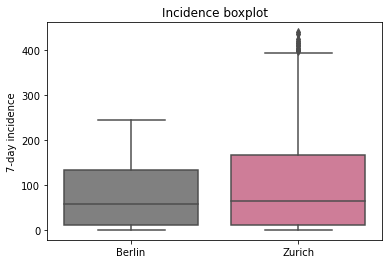

In [59]:
sns.boxplot(data = [cases_be.incidence, cases_zh.incidence], palette = ['gray','palevioletred']);
plt.xticks([0,1],['Berlin','Zurich']);
plt.title('Incidence boxplot');
plt.ylabel('7-day incidence');

The mean incidence in Caonton Zurich was considerably higher than in Berlin. However, the median values are similar in both locations. This implies some large outliers in the Zurich data, which is confirmed by the boxplot.

### Question 2:
How does the progress of incidences in Canton Zurich and Berlin compare? 

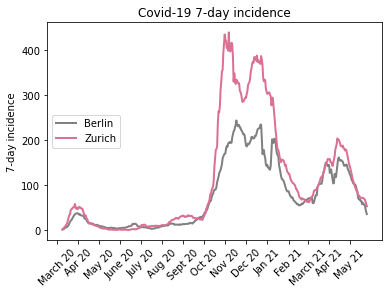

In [60]:
fig = plt.figure()
plot_temporal_data(plt.gca(), cases_be, 'incidence', color = 'gray', linewidth = 2, label = 'Berlin', 
                   ylabel = '7-day incidence', legend = 'in')
plot_temporal_data(plt.gca(), cases_zh, 'incidence', color = 'palevioletred', linewidth = 2, 
                   title = 'Covid-19 7-day incidence', label = 'Zurich', legend = 'in')
get_month_ticks(plt.gca(), 45)

In [61]:
diff = abs(cases_be.incidence - cases_zh.incidence)
print('The maximum difference in incidences between Berlin and Zurich was {} on {}'.format(round(max(diff)), 
    datetime.date(cases_be.date.iloc[diff.idxmax()])))

The maximum difference in incidences between Berlin and Zurich was 265 on 2020-10-31


The temporal progress of incidences shows a similar shape. However, the incidences in Zurich were much higher during the second wave, reaching a maximun in October 2020. 

### Question 3: 
What variables have influenced the progress of incidences in Canton Zurich and Berlin?

To begin with, I will plot both independent and dependet variables to get a visual impression.

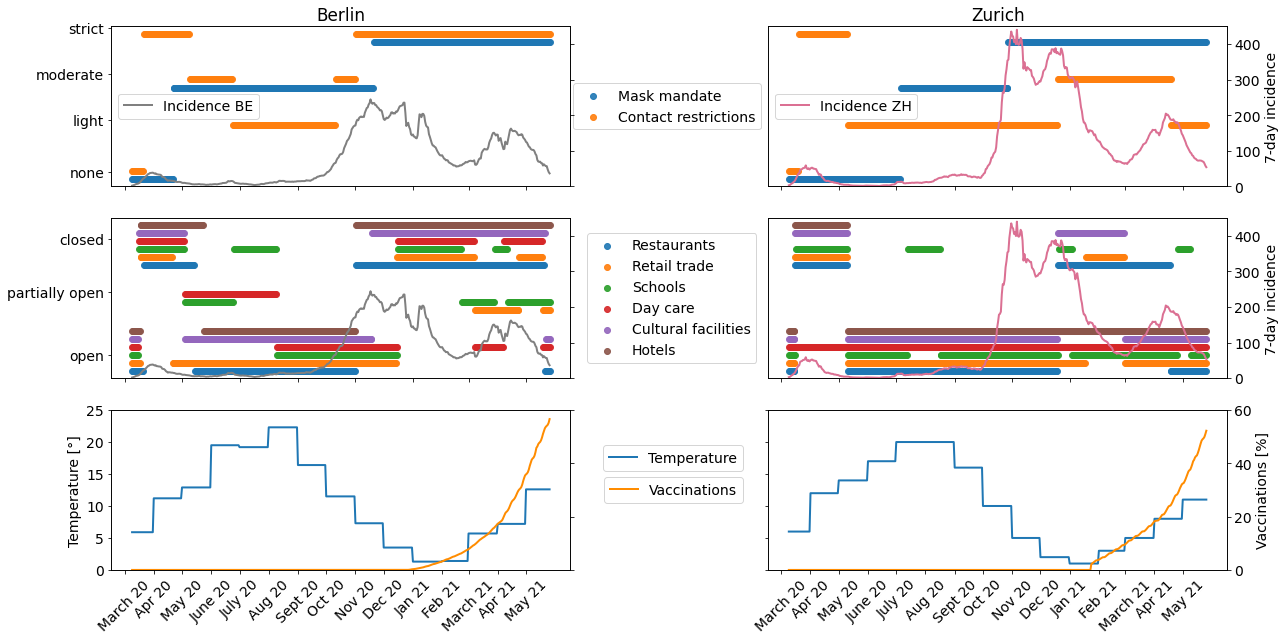

In [62]:
fig = plt.figure(figsize=(20,10));
plt.rcParams.update({'font.size': 14})
(ax1, ax2), (ax3, ax4), (ax5, ax6) = fig.subplots(3,2);
ax1_sec = ax1.twinx()
ax2_sec = ax2.twinx()
ax3_sec = ax3.twinx()
ax4_sec = ax4.twinx()
ax5_sec = ax5.twinx()
ax6_sec = ax6.twinx()

incidence_lim = [0, 450]
temp_lim = [0, 25]
vacc_lim = [0, 60]

# Berlin
plot_lockdowns(lockdowns_be, ax1, ax3, xticklabels = False) # lockdowns
plot_temporal_data(ax1_sec, cases_be, 'incidence', color = 'gray', linewidth = 2, label = 'Incidence BE',
                   title = 'Berlin', xticklabels = False, yticklabels = False, ylim = incidence_lim, legend = 'in')
plot_temporal_data(ax3_sec, cases_be, 'incidence', color = 'gray', linewidth = 2,
                   xticklabels = False, yticklabels = False, ylim = incidence_lim)
plot_temporal_data(ax5, temperature_be, 'temperature', label = 'Temperature', linewidth = 2,
                  ylabel = 'Temperature [°]', ylim = temp_lim, legend = 'out', lpos = (1.39, 0.7))
plot_temporal_data(ax5_sec, vacc_de, 'vacc_percent', color = 'darkorange', label = 'Vaccinations', linewidth = 2, 
                   yticklabels = False, ylim = vacc_lim, legend = 'out', lpos = (1.39, 0.5))
get_month_ticks(ax5, 45)  

# Zurich
plot_lockdowns(lockdowns_zh, ax2, ax4, xticklabels = False, yticklabels = False, legend = False) # lockdowns
plot_temporal_data(ax2_sec, cases_zh, 'incidence', color = 'palevioletred', linewidth = 2, label = 'Incidence ZH',
                   title = 'Zurich', xticklabels = False, ylabel = '7-day incidence', ylim = incidence_lim, 
                   legend = 'in')
plot_temporal_data(ax4_sec, cases_zh, 'incidence', color = 'palevioletred', linewidth = 2, xticklabels = False, 
                   ylabel = '7-day incidence', ylim = incidence_lim)
plot_temporal_data(ax6, temperature_zh, 'temperature', label = 'Temperature', linewidth = 2, 
                  yticklabels = False, ylim = temp_lim)
plot_temporal_data(ax6_sec, vacc_ch, 'vacc_percent', color = 'darkorange', label = 'Vaccinations', linewidth = 2, 
                   ylabel = 'Vaccinations [%]', ylim = vacc_lim)
get_month_ticks(ax6, 45)

plt.subplots_adjust(wspace = .43)

The above plots visualise the different handling of regulations in Berlin and Canton Zurich as well as temperatures and vaccinations. While the latter two are very similar for both locations, the differences in  the lockdown regulations become apparent. Especially during the second and third waves, the regulations were obviously much stricter in Berlin than in Zurich. 

#### PCA
The lockdown variables are highly correlated, which will cause problems when using them as explanatory variables in a prediction model. Therefore, I will reduce the number of variables with a PCA, assuming 4 - 5 components.

In [63]:
do_pca(lockdowns_be, 4)

          0         1         2         3             variables
0 -0.143695 -0.484430 -0.851408 -0.012026          mask_mandate
1 -0.388563 -0.277754  0.097264  0.328139  contact_restrictions
2 -0.438807 -0.209418  0.237766  0.156196           restaurants
3 -0.363967  0.247539 -0.091746 -0.635553          retail_trade
4 -0.210300  0.534573 -0.293154  0.515774               schools
5 -0.286767  0.513978 -0.212162  0.063899              day_care
6 -0.441249 -0.006497  0.059568 -0.393768   cultural_facilities
7 -0.426832 -0.181834  0.257283  0.196714                hotels
[0.63728064 0.16728693 0.08194325 0.04028755]


In [64]:
do_pca(lockdowns_zh, 4)

          0             1         2         3             variables
0 -0.312522 -8.467660e-01  0.309526 -0.160008          mask_mandate
1  0.361451 -1.664348e-01 -0.021103  0.406644  contact_restrictions
2  0.436469 -3.980328e-01 -0.192661  0.525748           restaurants
3  0.419089 -7.405147e-02 -0.175483 -0.590351          retail_trade
4  0.296901  1.520017e-01  0.906072  0.020210               schools
5 -0.000000  1.084202e-19 -0.000000 -0.000000              day_care
6  0.458173 -2.095448e-01 -0.080716 -0.427352   cultural_facilities
7  0.327828  1.560753e-01  0.091402  0.032790                hotels
[0.52283262 0.28580856 0.0996512  0.04589351]


One way to use the results of this PCA would be to calculate new variables based on the components. However, this might make these new variables difficult to interpret. Therefore I chose a different approach: for each component I selected the varialbe with the highest loading.

Berlin:
* Component 1: cultural_facilities
* Component 2: schools
* Component 3: mask_mandate
* Component 4: retail_trade

Zurich:
* Component 1: cultural_facilities
* Component 2: mask_mandate
* Component 3: schools
* Component 4: retail_trade

In [65]:
# define variables of lockdown data to be used for ARIMA
lockdown_vars = ['mask_mandate','retail_trade','schools','cultural_facilities']

#### ARIMA Model

Instead of using a regression model, I will use an ARIMA model for the analysis. This type of model is commonly used for the prediction of time series. Since the incidences are time series, this seems appropriate here.

I decided to drop the vaccination data as independent variable because the vaccinations only started in January 2021, but the model takes into account the whole time period starting from March 2020. Therefore, the vaccination data has no chance of being a powerful predictor. 

Values are z-transformed before analysis to account for the different measures.

In [66]:
X_be = pd.concat([lockdowns_be[lockdown_vars], temperature_be.temperature], axis = 1)
y_be = cases_be.incidence

res_be = do_ARIMA(X_be,y_be)

                               SARIMAX Results                                
Dep. Variable:              incidence   No. Observations:                  444
Model:                          ARIMA   Log Likelihood                -421.309
Date:                Sat, 19 Jun 2021   AIC                            856.618
Time:                        22:27:06   BIC                            885.289
Sample:                             0   HQIC                           867.924
                                - 444                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -5.07e-06      0.041     -0.000      1.000      -0.081       0.081
mask_mandate            0.2911      0.045      6.460      0.000       0.203       0.379
retail_trade    

In [67]:
X_zh = pd.concat([lockdowns_zh[lockdown_vars], temperature_zh.temperature], axis = 1)
y_zh = cases_be.incidence

res_zh = do_ARIMA(X_zh, y_zh)

                               SARIMAX Results                                
Dep. Variable:              incidence   No. Observations:                  444
Model:                          ARIMA   Log Likelihood                -306.225
Date:                Sat, 19 Jun 2021   AIC                            626.449
Time:                        22:27:07   BIC                            655.120
Sample:                             0   HQIC                           637.756
                                - 444                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4.999e-06      0.031     -0.000      1.000      -0.061       0.061
mask_mandate            0.2471      0.032      7.667      0.000       0.184       0.310
retail_trade    

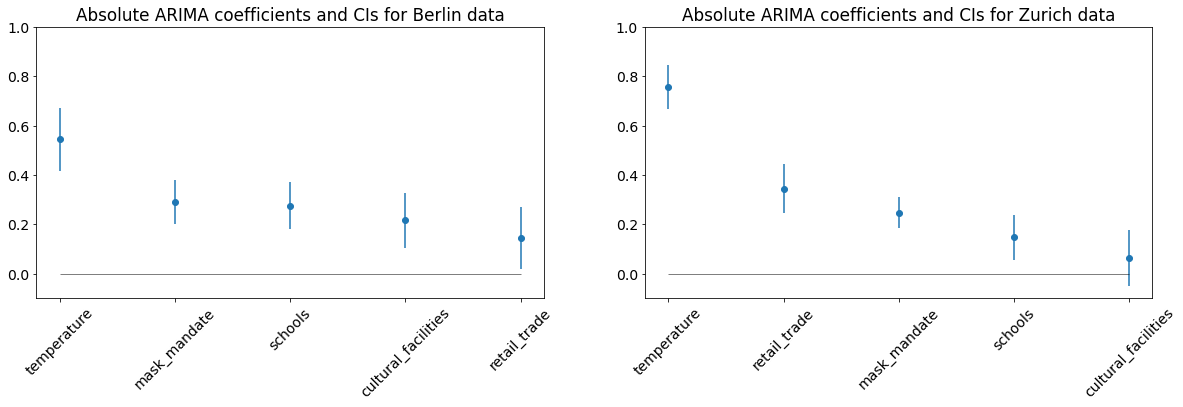

In [70]:
fig = plt.figure(figsize=(20,5));
plt.subplot(1,2,1)
plot_ARIMAcoefs(res_be)
plt.ylim((-.1,1));
plt.title('Absolute ARIMA coefficients and CIs for Berlin data');
plt.subplot(1,2,2)
plot_ARIMAcoefs(res_zh)
plt.ylim((-.1,1));
plt.title('Absolute ARIMA coefficients and CIs for Zurich data');

It is very interesting to see that in both loctations the temperature variable had the largest effect (largest coefficient) on the progress of incidences. This underlines the seasonal character of Covid-19. 

In Berlin the other four investigated variables all had a signifivant effect. This means the way the regulations for mask mandate, closing of schools, closing of cultural facilities and shops were handled did have an influence on the incidences. It is somewhat surprising that the coefficients for `mask_mandate` and `cultural_facilities` are positive, though. This implies increasing incidences with increasing strictness of regulations. 

In Zurich the way the closing of cultural facilities was handled did not have a significant effect on the incidences. The other regulations - closing retail trade, mask mandate and closing schools - did affect the incidences, though. As for Berlin, the coefficients for `mask_mandate` and `cultural_facilities` are positive, which is suprising.

## 5. Limitations <a id='limitations'></a>

There are a few things that can be optimised in this analysis:
* Take into account more/other lockdown regulations, for example the rules concerning home office
* Use a multilevel model to take into account the differences between the locations
* Analyise selected time periods, for example the 3 waves, individually 
* Use a more fine-graned categorisation for the strictness of the lockdown regulations